In [1]:
import zipfile
import urllib.request

def download_files():
    urllib.request.urlretrieve("https://github.com/hromi/SMILEsmileD/archive/refs/heads/master.zip", "./heads.zip")
    zip_ref = zipfile.ZipFile("./heads.zip", "r") #Opens the zip file in read mode
    zip_ref.extractall("./") #Extracts the files into the /tmp folder
    zip_ref.close()

Total rows 13,165
- training: 9,500 (72%)
- validation: 3,665 (28%)

In [3]:
import numpy as np
from os import listdir
from skimage.io import imread
from skimage.feature import hog

ROOT_DIRECTORY = "./SMILEsmileD-master/SMILEs"

def load_dir(path, label):
    loaded_images = []
    for name in listdir(path):
        try:
            loaded_images.append([path+name, label, hog(imread(path+name))])
        except Exception as e:
            print(e)
    return loaded_images

def load_dataset():
  images = np.array(load_dir(f"{ROOT_DIRECTORY}/negatives/negatives7/", 0) + \
          load_dir(f"{ROOT_DIRECTORY}/positives/positives7/", 1))
  np.random.shuffle(images)
  training, validation = np.split(images, [9_500])
  return training, validation

training, validation = load_dataset()
print(f"Training size {len(training)}")
print(f"Validation size {len(validation)}")

Could not find a backend to open `./SMILEsmileD-master/SMILEs/negatives/negatives7/negatives.zip`` with iomode `ri`.
Training size 9500
Validation size 3665


/var/folders/z_/p5t422z16619kv7q361n6fxh0000gn/T/ipykernel_63541/3048854799.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(load_dir(f"{ROOT_DIRECTORY}/negatives/negatives7/", 0) + \


In [4]:
import matplotlib.pyplot as plt

def display_image(image):
    img = imread(image)
    plt.axis("off")
    plt.imshow(img)
    print(img.shape)

def display_hog(image):
    fd, hog_image = hog(imread(image), visualize=True)
    plt.axis("off")
    plt.imshow(hog_image, cmap="gray")

def test_image(row, model):
    test_path, label, test_features = row
    display_image(test_path)
    prediction = model.predict([test_features])[0]
    print(f"Label: {label}, Prediction: {prediction}")


In [5]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


def generate_model(training, classifier, param_grid):
    X = np.stack(training[:, 2])
    Y = np.stack(training[:, 1])

    model = GridSearchCV(estimator=classifier(), param_grid=param_grid)
    model.fit(X, Y)
    print(f"Best parameters {model.best_params_}")

    return model


def get_metrics(validation, model):
    true_labels = np.stack(validation[:, 1])
    predictions = model.predict(np.stack(validation[:, 2]))
    matrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    print(classification_report(true_labels, predictions))

Best parameters {'C': 1.5, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2635
           1       0.86      0.81      0.84      1030

    accuracy                           0.91      3665
   macro avg       0.90      0.88      0.89      3665
weighted avg       0.91      0.91      0.91      3665



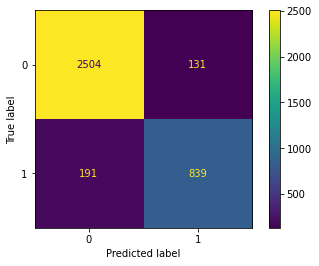

In [9]:
from sklearn.svm import SVC

svc_model = generate_model(training, SVC, {
    "kernel": ["rbf"],
    "C": [0.5, 1, 1.5],
})
get_metrics(validation, svc_model)

/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/svm/_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, 

Best parameters {'kernel': 'rbf', 'nu': 0.3}
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      2635
           1       0.87      0.79      0.83      1030

    accuracy                           0.91      3665
   macro avg       0.90      0.87      0.88      3665
weighted avg       0.91      0.91      0.91      3665



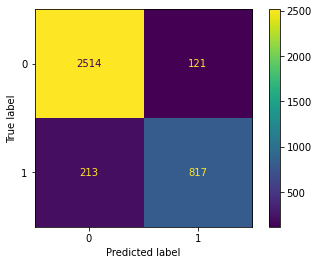

In [6]:
from sklearn.svm import NuSVC

nu_svc_model = generate_model(training, NuSVC, {
    "kernel": ["rbf"],
    "nu": [0.3, 0.5, 0.6],
})
get_metrics(validation, nu_svc_model)

/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.

Best parameters {'C': 1, 'loss': 'hinge', 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2635
           1       0.83      0.81      0.82      1030

    accuracy                           0.90      3665
   macro avg       0.88      0.87      0.88      3665
weighted avg       0.90      0.90      0.90      3665



/Users/david-rodriguez/Documents/Personal/Code/vision_computacional/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


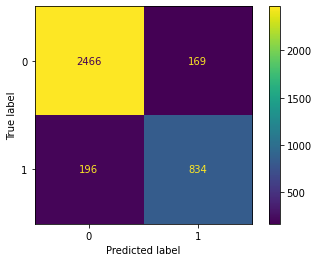

In [8]:
from sklearn.svm import LinearSVC

linear_svc_model = generate_model(training, LinearSVC, {
    "penalty": ["l1", "l2"],
    "loss": ["hinge"],
    "C": [1, 10],
})
get_metrics(validation, linear_svc_model)

In [10]:
from __future__ import print_function
import cv2 as cv


def detect_camera_smile(model):
    def detectAndDisplay(frame):
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frame_gray = cv.equalizeHist(frame_gray)
        faces = face_cascade.detectMultiScale(frame_gray)
        for (x, y, w, h) in faces:
            center = (x + w//2, y + h//2)
            frame = cv.rectangle(frame, [x, y], [x+w, y+h], (255, 0, 255))
            faceROI = cv.resize(frame_gray[y:y+h,x:x+w], dsize=(64, 64))
            text = "Smile" if model.predict([hog(faceROI)])[0] else "No smile"
            cv.putText(frame, text, (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
            
        cv.imshow('Capture - Face detection', frame)

    face_cascade_name = "./haarcascade_frontalface_default.xml"
    face_cascade = cv.CascadeClassifier()
    #-- 1. Load the cascades
    if not face_cascade.load(cv.samples.findFile(face_cascade_name)):
        print('--(!)Error loading face cascade')
        exit(0)
    cap = cv.VideoCapture(0)
    if not cap.isOpened:
        print('--(!)Error opening video capture')
        exit(0)
    while True:
        ret, frame = cap.read()
        if frame is None:
            print('--(!) No captured frame -- Break!')
            break
        detectAndDisplay(frame)
        if cv.waitKey(10) == 27:
            break

detect_camera_smile(svc_model)

KeyboardInterrupt: 

: 